In [1]:
import numpy as np

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_aer.primitives import Sampler
from qiskit_aer.backends import AerSimulator
from qiskit.circuit.library import TwoLocal
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit import transpile, QuantumCircuit
from matplotlib import pyplot as plt

from qiskit_optimization.translators import to_docplex_mp
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp

import gibbs_optimizer_v2 as opt

In [2]:
def generate_ms(m):
    n=10*(m-1)
    a=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            a[i,j]=np.random.randint(0,99)
    b=np.zeros(m)
    for j in range(m):
        bt=0
        for i in range(n):
            bt+=a[i,j]
        b[j]=np.floor(0.5 * bt)
    return a,b
    
generate_ms(2)

(array([[89., 91.],
        [42., 51.],
        [94., 69.],
        [ 4.,  7.],
        [ 3.,  6.],
        [23., 80.],
        [20., 17.],
        [80., 71.],
        [31., 47.],
        [55., 11.]]),
 array([220., 225.]))

In [2]:
with open('MS_9_80.npy','rb') as f:
    A = np.load(f)
    b = np.load(f)

scaling = np.max([np.abs(np.max(A)), np.abs(np.max(b))])

In [3]:
def map(x):
    x_map = []
    for i in x: 
        if np.abs(i) <= 0.5:
            x_map.append(1)
        else:
            x_map.append(0)
    return np.array(x_map)

In [4]:
def objective(x):
    return np.linalg.norm(b-x@A, ord=1)

In [5]:
num_qubits = A.shape[0] 
print(f'number of system qubits: {num_qubits}')

number of system qubits: 80


In [6]:
reps = 2

ansatz = TwoLocal(
    num_qubits = num_qubits,
    rotation_blocks = 'ry', 
    entanglement_blocks = 'cz',
    entanglement = 'pairwise', 
    reps = reps,
    insert_barriers = True
    )

n_params = ansatz.num_parameters
print(f'number of params: {n_params}')

number of params: 240


In [7]:
shots = 2**15

from qiskit_aer.primitives import Sampler
sampler = Sampler(backend_options={'method' : 'matrix_product_state', 'n_qubits': num_qubits})
sampler.set_options(shots=shots)

QuantumOptimizer = opt.Quantum_Optimizer()
QuantumOptimizer.set_optimizer(num_qubits, ansatz, sampler)
theta_initial = np.random.choice([np.pi/2, 0], size=(reps+1)*num_qubits, p=[.5, .5])

In [ ]:
import time
from collections import defaultdict
import pickle

prob_list = defaultdict(list)
log = defaultdict(list)

for itrial in range(0, 1):
    theta = theta_initial
    for beta in [1.0]:
        st = time.time()
        opt_run = QuantumOptimizer.run(
            objective = objective, 
            qc_params_init = theta_initial,
            scaling = scaling,
            max_epoch = 2,  
            intermediate_result_display = True,
            refval = None,
            alpha = 1.0, #cVAR param
            beta = beta,
        )
        #theta = opt_run['theta']
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial) + '_gibbs_obj_'
        with open('market_share/' + filename, 'wb') as fp:
            pickle.dump(opt_run['fval_log'], fp)
        
        print(time.time() - st)

epoch 0 	 step 0 	 exp_evals 1 	 cvar 0.833 	 fval 243.00253295898438 	 fevals 32768 	 best val 244.0
epoch 0 	 step 1 	 exp_evals 4 	 cvar 0.807 	 fval 283.0025329589844 	 fevals 131072 	 best val 189.0
epoch 0 	 step 2 	 exp_evals 7 	 cvar 0.808 	 fval 215.00253295898438 	 fevals 229376 	 best val 189.0
epoch 0 	 step 3 	 exp_evals 10 	 cvar 0.785 	 fval 213.00253295898438 	 fevals 327680 	 best val 189.0
epoch 0 	 step 4 	 exp_evals 13 	 cvar 0.771 	 fval 249.00253295898435 	 fevals 425984 	 best val 189.0
epoch 0 	 step 5 	 exp_evals 16 	 cvar 0.766 	 fval 291.0025329589844 	 fevals 524288 	 best val 189.0
epoch 0 	 step 6 	 exp_evals 19 	 cvar 0.767 	 fval 213.00253295898438 	 fevals 622592 	 best val 189.0
epoch 0 	 step 7 	 exp_evals 22 	 cvar 0.768 	 fval 263.0025329589844 	 fevals 720896 	 best val 189.0
epoch 0 	 step 8 	 exp_evals 25 	 cvar 0.765 	 fval 279.0025329589844 	 fevals 819200 	 best val 152.0
epoch 0 	 step 9 	 exp_evals 28 	 cvar 0.768 	 fval 207.00253295898438 	

## Optimizing beta

In [9]:
from scipy.optimize import minimize


theta_0 = np.random.choice([np.pi/2, 0], size=(reps+1)*num_qubits, p=[.5, .5])

def vqe_loop(x):
    
    global theta_0 
    
    QuantumOptimizer = opt.Quantum_Optimizer()
    QuantumOptimizer.set_optimizer(num_qubits, ansatz, sampler)
    
    opt_run = QuantumOptimizer.run(
        objective = objective, 
        qc_params_init = theta_0,
        scaling = scaling,
        max_sweep = 10,  
        intermediate_result_display = True,
        refval = None,
        alpha = 1.0, #cVAR param
        beta = x,
    )
    theta_0 = opt_run['theta'][:]
    
    return opt_run['expec_log'][-1]

minimize(vqe_loop, 0.1)

epoch 0 	 step 0 	 exp_evals 2060.462493896489 	 best val 243.0
epoch 0 	 step 1 	 exp_evals 2027.1511840820199 	 best val 195.0
epoch 0 	 step 2 	 exp_evals 1877.3227844238288 	 best val 195.0
epoch 0 	 step 3 	 exp_evals 1870.5840454101576 	 best val 173.0
epoch 0 	 step 4 	 exp_evals 1859.182922363273 	 best val 173.0
epoch 0 	 step 5 	 exp_evals 1865.1424255371073 	 best val 153.0
epoch 0 	 step 6 	 exp_evals 1866.7467346191333 	 best val 153.0
epoch 0 	 step 7 	 exp_evals 1864.7747497558626 	 best val 153.0
epoch 0 	 step 8 	 exp_evals 1818.0050354003902 	 best val 153.0
epoch 0 	 step 9 	 exp_evals 1812.0975036620907 	 best val 153.0
epoch 0 	 step 10 	 exp_evals 1817.296569824224 	 best val 153.0
final: 	 best val = 0.070
epoch 0 	 step 0 	 exp_evals 1822.466186523443 	 best val 224.0
epoch 0 	 step 1 	 exp_evals 1793.671264648436 	 best val 224.0
epoch 0 	 step 2 	 exp_evals 1671.0865783691509 	 best val 175.0
epoch 0 	 step 3 	 exp_evals 1583.7067565917966 	 best val 175.0
epo

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 917.1383056640669
        x: [ 1.004e-01]
      nit: 4
      jac: [-3.279e+07]
 hess_inv: [[ 3.099e-18]]
     nfev: 49
     njev: 19

In [1]:
opt_run['theta']

NameError: name 'opt_run' is not defined

In [44]:
import pickle

all_log = []
for beta in [0.01, 0.1, 1.0, 2.0, 4.0]:
    for itrial in range(4, 5):
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
        with open('results_anneal/' + filename, 'rb') as fp:
            log = pickle.load(fp)
    all_log.append(log)

(-100.0, 0.0)

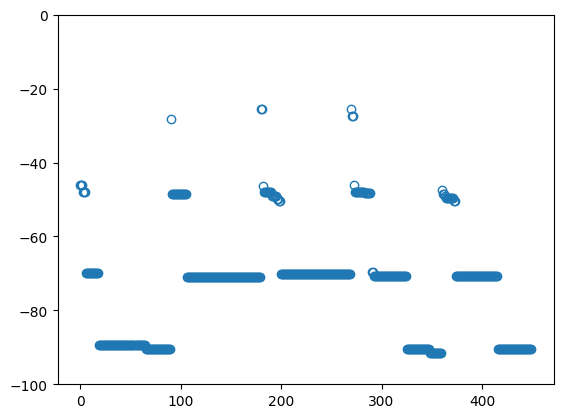

In [45]:
import matplotlib.pyplot as plt
y = []
for elem, k in zip(all_log, range(0, len(all_log))):
    for i in range(0, len(elem)):
        y.append(elem[i])
plt.plot(range(0, len(y)), y, 'o', mfc='none')
plt.ylim([-100.0, 0.0])
#plt.legend([0.01, 0.1, 1.0, 2.0, 4.0])

In [45]:
all_log[1][356]

-0.2429078014184398

In [ ]:
qc = ansatz.bind_parameters(opt_run['theta'])
qc.measure_all()

job = sampler.run(qc)
result = job.result()
quasi_dist = result.quasi_dists[0]
prob_dict = quasi_dist.binary_probabilities()
prob_list[beta].append(prob_dict)  

In [ ]:
from itertools import product
import matplotlib.pyplot as plt

ee = {}
prob = {}

bit_str = [''.join(p) for p in product('10', repeat=num_qubits)]

def energy(x):
    x = np.array(list(x)).astype(int)
    x = np.flip(x) 
    return x @ Q @ x

for beta in np.arange(0.5, 0.6, 0.1):
    Z = 0.0
    for elem in bit_str:
        ee[elem] = objective([int(i) for i in elem])
        prob[elem] = np.exp(-beta * ee[elem])
        Z+= prob[elem]
    
    prob_ee = {k:(v/Z) for (k,v) in zip(ee.values(), prob.values())}
    plt.plot(prob_ee.keys(), prob_ee.values(), 'o')
    plt.plot([energy(x) for x in prob_list[0.5][0].keys()], prob_list[0.5][0].values(), 'o')
    #plt.yscale('log')

In [ ]:
fid = 0.0
for bit_str, val in prob.items():
    if bit_str in prob_list[0.5][0].keys():
        fid+= prob[bit_str] * prob_list[0.5][0][bit_str]
fid

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table